In [1]:
# Google colab link: https://colab.research.google.com/drive/1gp-AwDvdchMGJaODYjJOtaDLhfg1ifj4

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
import pandas as pd
import numpy as np

# Read data
train = pd.read_csv('train-balanced-sarcasm.csv')
train = train.dropna(subset = ['comment']) # drop na values

In [0]:
# without meta-data
# for meta-data, do same as SVM and Logistic Regression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# use CountVectorizer for comparison 
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 2), stop_words = 'english', max_features = 500) 
one_hot = tfidf_vectorizer.fit_transform(train['comment']).toarray()

In [4]:
print(one_hot.shape)
y = np.asarray(train['label'])
print(y.shape)
np.random.seed(1001)
mask = np.random.rand((len(y))) # for train-test split

(1010773, 500)
(1010773,)


In [5]:
x_train = torch.from_numpy(one_hot[mask <= 0.85])
x_test = torch.from_numpy(one_hot[mask > 0.85])
print(x_train.shape, x_test.shape)

torch.Size([859133, 500]) torch.Size([151640, 500])


In [6]:
y_train = torch.from_numpy(y[mask <= 0.85])
y_test = torch.from_numpy(y[mask > 0.85])
print(y_train.shape, y_test.shape)

torch.Size([859133]) torch.Size([151640])


In [0]:
train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test)
# Data loader
train_loader = DataLoader(train, batch_size = 500, shuffle = True)
test_loader = DataLoader(test, batch_size = 500, shuffle = False)

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Hyper-parameters
sequence_length = 25
input_size = 20
hidden_size = 128
num_layers = 2
num_classes = 2
batch_size = 500
num_epochs = 200
learning_rate = 0.001

In [0]:
# Recurrent neural network 
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [0]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [40]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
losses = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        model.to(device)
        inputs, labels = inputs.float(), labels.long()
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device) # move to GPU
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print("Epoch: ", epoch + 1, ", Loss: ", running_loss / total_step)
    losses.append(running_loss / total_step)

Epoch:  1 , Loss:  0.6657625700305408
Epoch:  2 , Loss:  0.6517248444254833
Epoch:  3 , Loss:  0.6472949348541801
Epoch:  4 , Loss:  0.6444969481337272
Epoch:  5 , Loss:  0.6423528320640932
Epoch:  6 , Loss:  0.6406939564367031
Epoch:  7 , Loss:  0.6390961499114312
Epoch:  8 , Loss:  0.6378630514474994
Epoch:  9 , Loss:  0.6364067069592345
Epoch:  10 , Loss:  0.6352862665443798
Epoch:  11 , Loss:  0.6340715009990024
Epoch:  12 , Loss:  0.6329189243879757
Epoch:  13 , Loss:  0.631758556107992
Epoch:  14 , Loss:  0.6306844728502026
Epoch:  15 , Loss:  0.6297587964893983
Epoch:  16 , Loss:  0.6286483686839931
Epoch:  17 , Loss:  0.627662649225398
Epoch:  18 , Loss:  0.6264551293718184
Epoch:  19 , Loss:  0.6253795435152614
Epoch:  20 , Loss:  0.6243506327072086
Epoch:  21 , Loss:  0.6230307885073451
Epoch:  22 , Loss:  0.6218619414579737
Epoch:  23 , Loss:  0.6205841630541217
Epoch:  24 , Loss:  0.6191281058401338
Epoch:  25 , Loss:  0.617603438582928
Epoch:  26 , Loss:  0.616160477123127

200
200



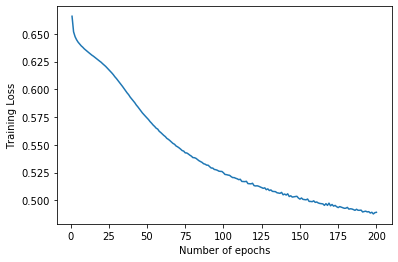

In [41]:
import matplotlib.pyplot as plt
print(len(losses)) # sanity check
epochs = []
for i in range(1, 201): 
    epochs.append(i)
print(len(epochs)) # sanity check
print()
plt.plot(epochs, losses)
plt.xlabel('Number of epochs')
plt.ylabel('Training Loss')
plt.show()

In [42]:
# Performance on train set
with torch.no_grad():
    correct, total = 0, 0
    tp, fp, fn, tn = 0, 0, 0, 0 # for confusion matrix
    for i, data in enumerate(train_loader, 0): 
        inputs, labels = data 
        model.to(device) 
        inputs, labels = inputs.float(), labels.long()
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device) # move to GPU
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # true positives
        tp += (predicted[labels == 1] == labels[labels == 1]).sum().item()
        # false negatives
        fn += (predicted[labels == 1] != labels[labels == 1]).sum().item()
        # false positives
        fp += (predicted[labels == 0] != labels[labels == 0]).sum().item()
        # true negatives
        tn += (predicted[labels == 0] == labels[labels == 0]).sum().item()
        precision = (tp / (tp + fp))
        recall =  (tp / (tp + fn))
        f1 = 2 * (precision * recall) / (precision + recall)

print("Recurrent Neural Network for TF-IDF vectorization:")
print("Training accuracy: ", (100 * correct) / total)
print("Precision: ", precision, " | Recall: ", recall, " | F1-score: ", f1)
print("Confusion matrix values: ")
print("TP: ", tp, ", FN: ", fn, ", FP: ", fp, ", TN: ", tn)

Recurrent Neural Network for TF-IDF vectorization:
Training accuracy:  73.37757949002075
Precision:  0.7994965942573572  | Recall:  0.6240694269206237  | F1-score:  0.7009739962609003
Confusion matrix values: 
TP:  268084 , FN:  161490 , FP:  67232 , TN:  362327


In [45]:
# Performance on test set
with torch.no_grad():
    correct, total = 0, 0
    tp, fp, fn, tn = 0, 0, 0, 0 # for confusion matrix
    for i, data in enumerate(test_loader, 0): 
        inputs, labels = data 
        model.to(device) 
        inputs, labels = inputs.float(), labels.long()
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device) # move to GPU
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # true positives
        tp += (predicted[labels == 1] == labels[labels == 1]).sum().item()
        # false negatives
        fn += (predicted[labels == 1] != labels[labels == 1]).sum().item()
        # false positives
        fp += (predicted[labels == 0] != labels[labels == 0]).sum().item()
        # true negatives
        tn += (predicted[labels == 0] == labels[labels == 0]).sum().item()
        precision = (tp / (tp + fp))
        recall =  (tp / (tp + fn))
        f1 = 2 * (precision * recall) / (precision + recall)

print("Testing accuracy: ", (100 * correct) / total)
print("Precision: ", precision, " | Recall: ", recall, " | F1-score: ", f1)
print("Confusion matrix values: ")
print("TP: ", tp, ", FN: ", fn, ", FP: ", fp, ", TN: ", tn)

Testing accuracy:  68.12582432075969
Precision:  0.7097935365196156  | Recall:  0.598457095488943  | F1-score:  0.6493877669452183
Confusion matrix values: 
TP:  44761 , FN:  30033 , FP:  18301 , TN:  58545
